In [1]:
import os
import pywt
import glob
import random
import datetime
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-07-11 14:06:58.814931: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 14:07:02.026280: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load data and preprocess

In [2]:
xTrain = np.load("./xTrain.npy")
yTrain = np.load("./yTrain.npy", allow_pickle=True)

xTest = np.load("./xTest.npy")
yTest = np.load("./yTest.npy", allow_pickle=True)

In [3]:
# Columns are:
#
# 0 = 'Beta_p'
# 1 = 'Va'
# 2 = 'Tratio'
# 3 = 'entropy'
# 4 = 'crossHelicity'
# 5 = 'residualEnergy'
# 6 = 'TotalPressure'
# 7 = 'bFluctuations'

In [3]:
remove = [0,4,5,6,7]
xTrain = np.delete(xTrain, remove, 1) 
xTest = np.delete(xTest, remove, 1) 

In [4]:
xTrain.shape

(48975, 3)

In [5]:
# remove sheath
ixTrain = np.where(yTrain != 4)
ixTest = np.where(yTest != 4)

xTrain = xTrain[ixTrain,:]
xTest = xTest[ixTest,:]

yTrain = yTrain[ixTrain]
yTest = yTest[ixTest]

xTrain = xTrain[0,:,:]
xTest = xTest[0,:,:]

In [6]:
nClasses = len( np. unique( yTrain ) )
nClasses

4

In [7]:
xTrain.shape,xTest.shape,yTrain.shape,yTest.shape

((39168, 3), (9813, 3), (39168,), (9813,))

In [8]:
y = tf.one_hot(yTrain,nClasses)

2024-07-11 14:07:22.814919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5337 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:65:00.0, compute capability: 3.5


### Neural Network

In [9]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

In [10]:
def create_probablistic_bnn_model(rows,columns):
    
    inputs = tf.keras.layers.Input(shape=columns)
    
    hidden1 = tf.keras.layers.Dense(16, activation='relu')(inputs)
    hidden2 = tf.keras.layers.Dense(8, activation='relu')(hidden1)
    
    distribution_params = layers.Dense(nClasses)(hidden2)
    outputs = tfp.layers.OneHotCategorical(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [11]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [13]:
bnn = create_probablistic_bnn_model(xTrain.shape[0],xTrain.shape[1])
bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 one_hot_categorical (OneHot  ((None, 4),              0         
 Categorical)                 (None, 4))                         
                                                                 
Total params: 236
Trainable params: 236
Non-trainable params: 0
_______________________________________________________________

In [14]:
bnn.compile( loss=negative_loglikelihood, metrics=['accuracy'] )

In [15]:
history = bnn.fit( xTrain, y, epochs=200, verbose=1, 
                  use_multiprocessing=True, validation_split=0.2)

Epoch 1/200


2024-01-17 12:51:55.711690: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f9a08024ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 12:51:55.711758: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN Black, Compute Capability 3.5
2024-01-17 12:51:55.725101: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-17 12:51:55.931368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-01-17 12:51:55.977814: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-17 12:51:56.040016: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


980/980 [==============================] - 7s 6ms/step - loss: 1.2337 - accuracy: 0.2979 - val_loss: 1.0379 - val_accuracy: 0.3864
Epoch 2/200
980/980 [==============================] - 5s 6ms/step - loss: 0.9206 - accuracy: 0.4398 - val_loss: 0.8512 - val_accuracy: 0.4774
Epoch 3/200
980/980 [==============================] - 5s 6ms/step - loss: 0.7745 - accuracy: 0.5172 - val_loss: 0.7140 - val_accuracy: 0.5523
Epoch 4/200
980/980 [==============================] - 5s 6ms/step - loss: 0.6534 - accuracy: 0.5981 - val_loss: 0.6100 - val_accuracy: 0.6316
Epoch 5/200
980/980 [==============================] - 6s 6ms/step - loss: 0.5709 - accuracy: 0.6568 - val_loss: 0.5506 - val_accuracy: 0.6800
Epoch 6/200
980/980 [==============================] - 5s 6ms/step - loss: 0.5190 - accuracy: 0.6919 - val_loss: 0.5028 - val_accuracy: 0.6986
Epoch 7/200
980/980 [==============================] - 5s 6ms/step - loss: 0.4840 - accuracy: 0.7091 - val_loss: 0.4757 - val_accuracy: 0.7178
Epoch 8/200

980/980 [==============================] - 5s 6ms/step - loss: 0.3208 - accuracy: 0.8215 - val_loss: 0.3220 - val_accuracy: 0.8237
Epoch 59/200
980/980 [==============================] - 5s 5ms/step - loss: 0.3194 - accuracy: 0.8247 - val_loss: 0.3491 - val_accuracy: 0.8148
Epoch 60/200
980/980 [==============================] - 5s 5ms/step - loss: 0.3194 - accuracy: 0.8234 - val_loss: 0.3260 - val_accuracy: 0.8153
Epoch 61/200
980/980 [==============================] - 5s 6ms/step - loss: 0.3184 - accuracy: 0.8228 - val_loss: 0.3338 - val_accuracy: 0.8258
Epoch 62/200
980/980 [==============================] - 5s 6ms/step - loss: 0.3174 - accuracy: 0.8257 - val_loss: 0.3331 - val_accuracy: 0.8078
Epoch 63/200
980/980 [==============================] - 5s 6ms/step - loss: 0.3170 - accuracy: 0.8250 - val_loss: 0.3279 - val_accuracy: 0.8250
Epoch 64/200
980/980 [==============================] - 5s 6ms/step - loss: 0.3159 - accuracy: 0.8246 - val_loss: 0.3190 - val_accuracy: 0.8214
Epoch

Epoch 115/200
980/980 [==============================] - 5s 6ms/step - loss: 0.2821 - accuracy: 0.8392 - val_loss: 0.2817 - val_accuracy: 0.8427
Epoch 116/200
980/980 [==============================] - 5s 6ms/step - loss: 0.2812 - accuracy: 0.8422 - val_loss: 0.2864 - val_accuracy: 0.8384
Epoch 117/200
980/980 [==============================] - 5s 6ms/step - loss: 0.2808 - accuracy: 0.8398 - val_loss: 0.2850 - val_accuracy: 0.8412
Epoch 118/200
980/980 [==============================] - 5s 5ms/step - loss: 0.2806 - accuracy: 0.8435 - val_loss: 0.2887 - val_accuracy: 0.8444
Epoch 119/200
980/980 [==============================] - 5s 6ms/step - loss: 0.2801 - accuracy: 0.8416 - val_loss: 0.3015 - val_accuracy: 0.8491
Epoch 120/200
980/980 [==============================] - 5s 6ms/step - loss: 0.2799 - accuracy: 0.8415 - val_loss: 0.2860 - val_accuracy: 0.8324
Epoch 121/200
980/980 [==============================] - 5s 6ms/step - loss: 0.2791 - accuracy: 0.8402 - val_loss: 0.3177 - val_ac

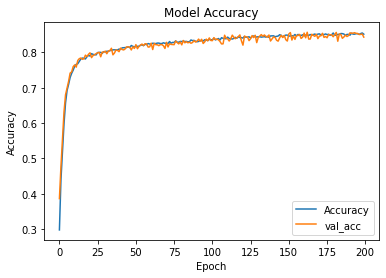

In [16]:
plt.plot( history.history['accuracy'], label="Accuracy")
plt.plot( history.history['val_accuracy'], label="val_acc")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

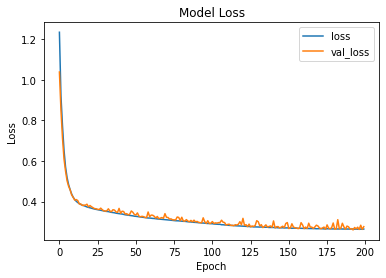

In [17]:
plt.plot( history.history['loss'], label="loss")
plt.plot( history.history['val_loss'], label="val_loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [18]:
# serialize weights to HDF5
bnn.save_weights("./model_weights_3PNN_no_sheath.h5")

In [19]:
from scipy.stats import entropy

preds = []
en = bnn(xTest).entropy()

p = bnn(xTest)
for i in range(p.shape[0]):
    preds.append( np.argmax(p[i,:]) )

In [20]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 24}
plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


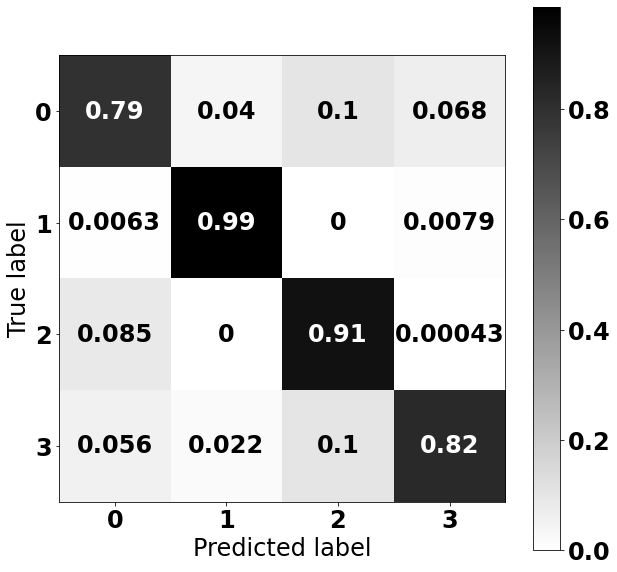

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))

cm = confusion_matrix( yTest.astype(int), preds, normalize='true' )
disp = ConfusionMatrixDisplay( confusion_matrix=cm )
disp.plot(ax=ax, cmap='gist_yarg')

In [22]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

yTest = yTest.astype(int)

print( "Macro F1:", np.round( f1_score(yTest, preds, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(yTest, preds, average='macro'), 4 ))
print( "Macro Recall:", np.round( recall_score(yTest, preds, average='macro'), 4 ))
print( "Accuracy:", np.round( accuracy_score(yTest, preds), 4 ))

Macro F1: 0.8764
Macro Precision: 0.8783
Macro Recall: 0.8779
Accuracy: 0.8779


### If model was already trained - Load the saved model for analysis

In [12]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

bnn = create_probablistic_bnn_model( xTest.shape[0], xTest.shape[1] )
 
# load weights into new model
bnn.load_weights("./model_weights_3PNN_no_sheath.h5")

In [13]:
from scipy.stats import entropy

preds = []
en = bnn(xTest).entropy()

p = bnn(xTest)
for i in range(p.shape[0]):
    preds.append( np.argmax(p[i,:]) )